In [1]:
from xgboost import XGBRegressor
import random

import sys
sys.path.append('..')

from utils.data_loaders import get_wake_datasets
from utils.evaluation import evaluate_model
import utils.plotting as plotting

In [3]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"../data/{FACTORS_FOLDER}/"
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
#INPUT_VAR_TO_TRAIN_RANGES = {'ti': [(0.15, 0.4)], 'ct': [(0.3, 0.7)]}
#train_range_string = "training_ranges=" + '-'.join([f"{var}{r[0]}-{r[1]}" for var, ranges in INPUT_VAR_TO_TRAIN_RANGES.items() for r in ranges])
CONSIDER_WS = False
COORDS_AS_INPUT = True # univariate setting

MODEL_NAME = f"univariate_XGB_{train_reduc_factor_string}"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
MODEL_DESCRIPTION=MODEL_NAME+"_"+FACTORS_FOLDER
print(MODEL_DESCRIPTION)

univariate_XGB_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01


In [5]:
train_dataset, valid_dataset, test_dataset = get_wake_datasets(DATA_FOLDER,
                                                               consider_ws=CONSIDER_WS,
                                                               coords_as_input=COORDS_AS_INPUT,
                                                               #train_perc=0.6,
                                                               #validation_perc=0.2,
                                                               #test_perc=0.2
                                                               input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
                                                               )

train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)

grid_size = train_dataset.num_cells
print(f"{grid_size=}")

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:230: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the reduction factors for the training set instead:
{'ti': 4, 'ct': 4}
  warnings.warn(


Train shapes:  torch.Size([3942400, 4]) torch.Size([3942400, 1])
grid_size=7168


In [6]:
train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)
train_size = train_x.shape[0]

test_x, test_y = test_dataset.inputs, test_dataset.outputs
print("Test shapes: ", test_x.shape, test_y.shape)
test_size = test_x.shape[0]

valid_x, valid_y = valid_dataset.inputs, valid_dataset.outputs
print("Valid shapes: ", valid_x.shape, valid_y.shape)
valid_size = valid_x.shape[0]

size = train_size + test_size + valid_size
print(train_size/size, test_size/size, valid_size/size)

Train shapes:  torch.Size([3942400, 4]) torch.Size([3942400, 1])
Test shapes:  torch.Size([28851200, 4]) torch.Size([28851200, 1])
Valid shapes:  torch.Size([28851200, 4]) torch.Size([28851200, 1])
0.06395348837209303 0.4680232558139535 0.4680232558139535


# Training

In [9]:
model = XGBRegressor()
model.fit(train_x, train_y)
#tree_text = export_text(model)
#print(tree_text)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [10]:
importances = model.feature_importances_
for featurenum, importance in enumerate(importances):
    featurename = train_dataset.featurenum_to_featurename(featurenum)
    print(f"{featurename} feature importance={importance}")

ti feature importance=0.26187822222709656
ct feature importance=0.2547900080680847
x/D feature importance=0.1714530736207962
y/D feature importance=0.31187868118286133


# Evaluation and testing

In [13]:
# evaluation on trainset
save_results = True
evaluate_model(model, data=(train_x, train_y), data_type='train',
               model_description=MODEL_DESCRIPTION,
               save_results=save_results)

print("\n")

# evalution on testset
evaluate_model(model, data=(test_x, test_y), data_type='test',
               model_description=MODEL_DESCRIPTION,
               save_results=save_results)

Train results for univariate_XGB_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
r2_score=0.995512735046536
explained_variance_score=0.9955127239227295
mean_squared_error=5.57916791876778e-06
mean_absolute_error=0.0011969089973717928
median_absolute_error=0.0005868002772331238
mean_absolute_percentage_error=44121755648.0
Prediction time=3.5607473707044277e-07s


Test results for univariate_XGB_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
r2_score=0.9887933426075529
explained_variance_score=0.9887992739677429
mean_squared_error=1.256640098290518e-05
mean_absolute_error=0.001553232199512422
median_absolute_error=0.0006921868771314621
mean_absolute_percentage_error=23376187392.0
Prediction time=3.2033912586287895e-07s


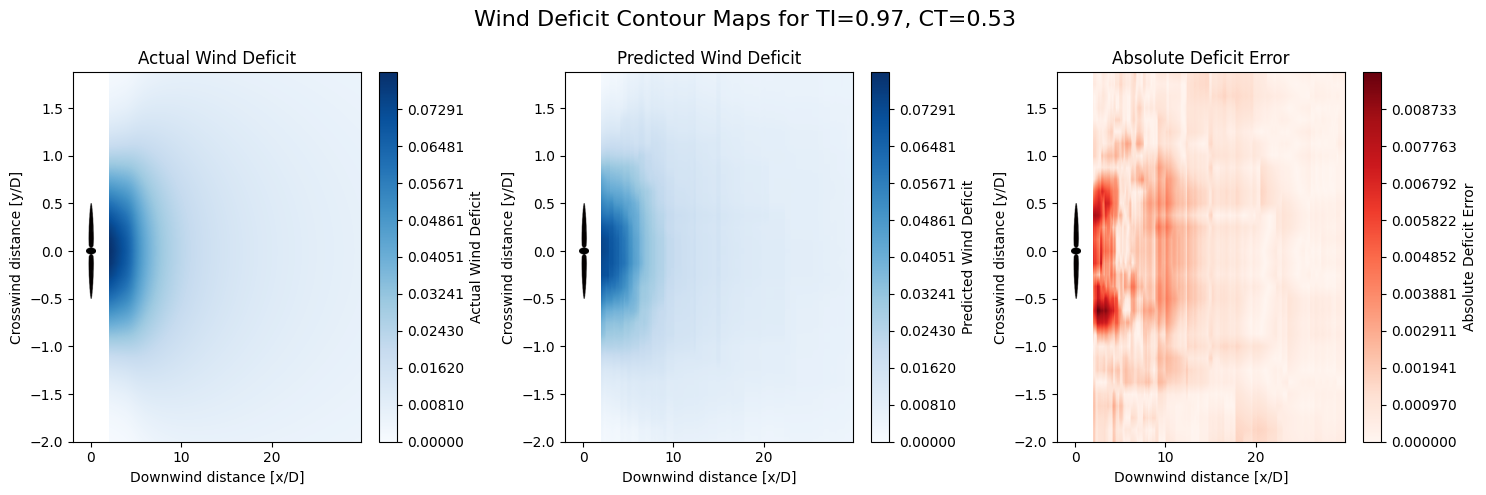

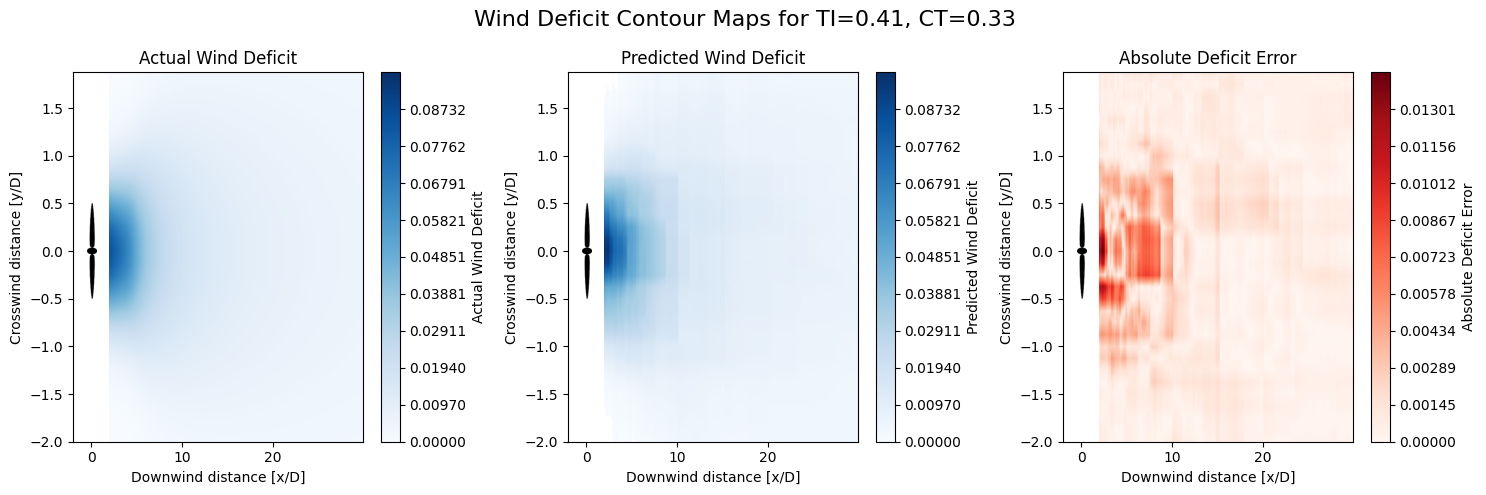

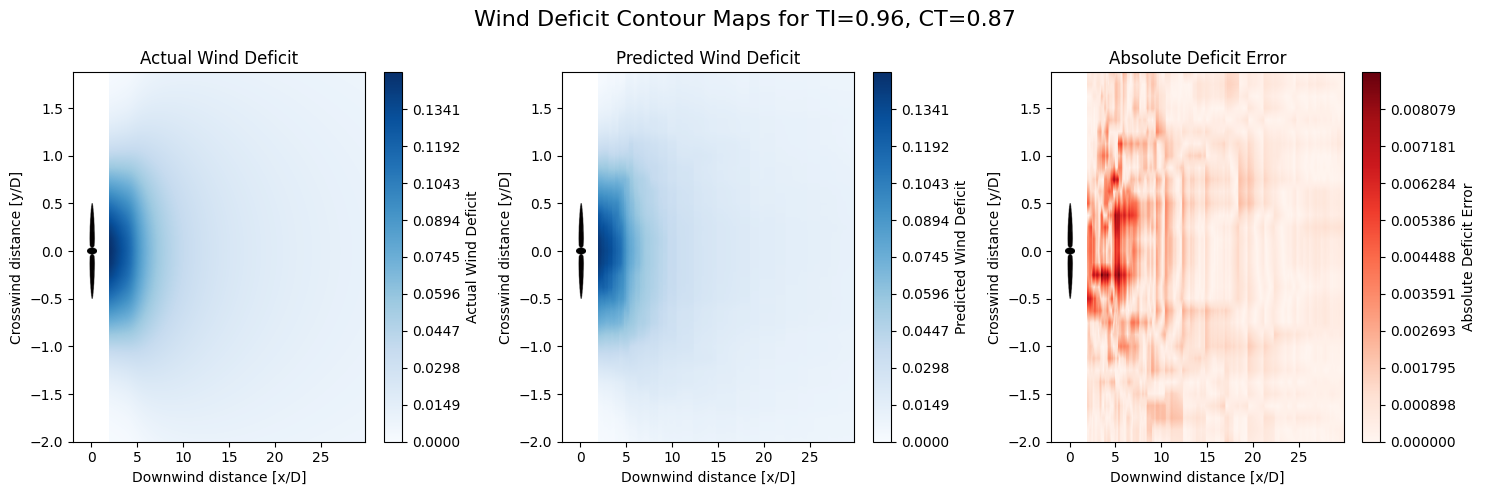

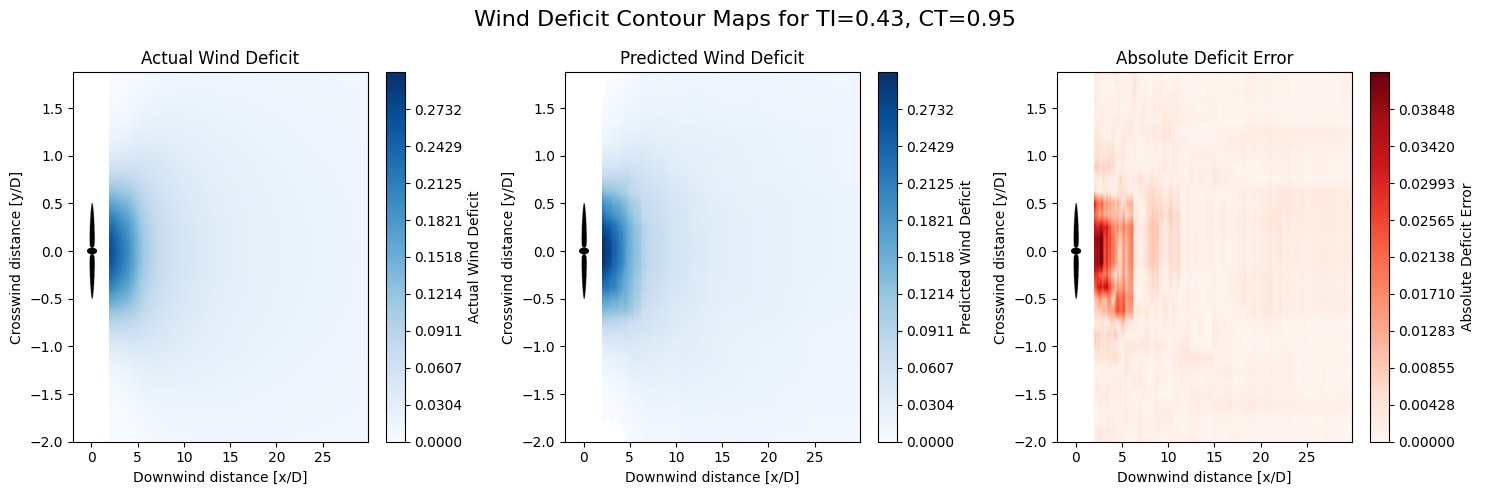

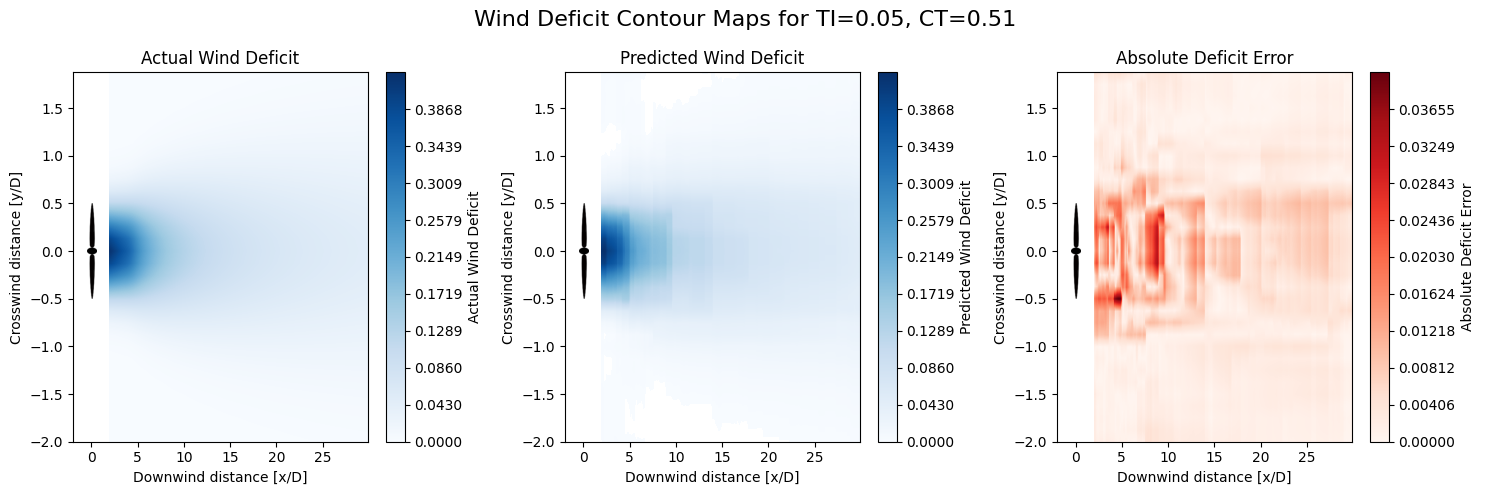

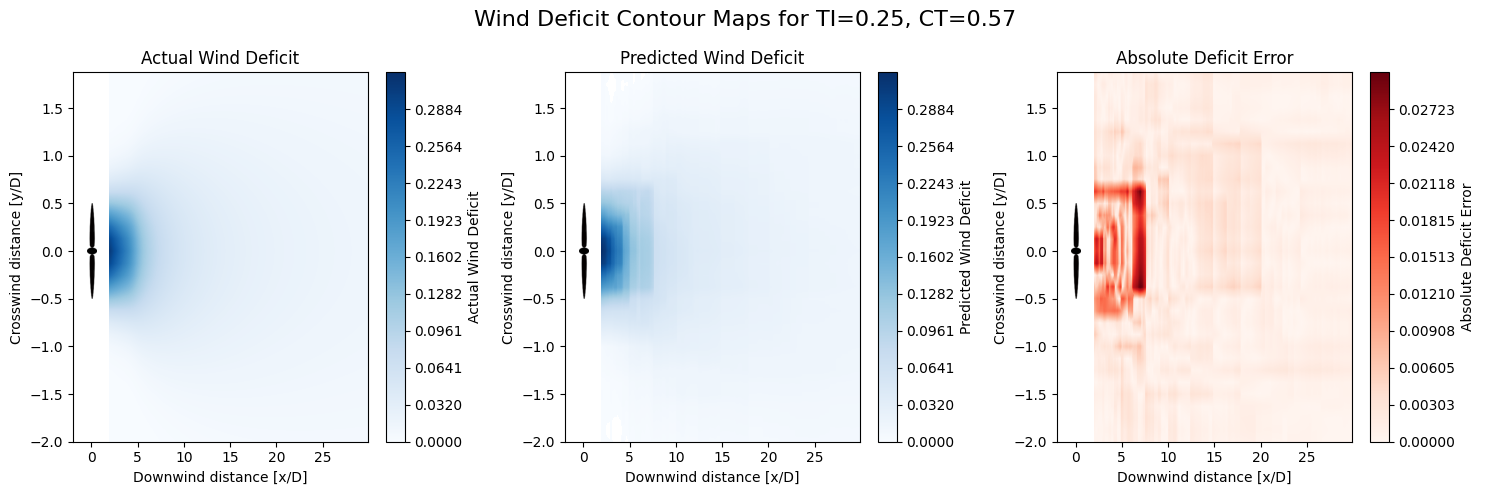

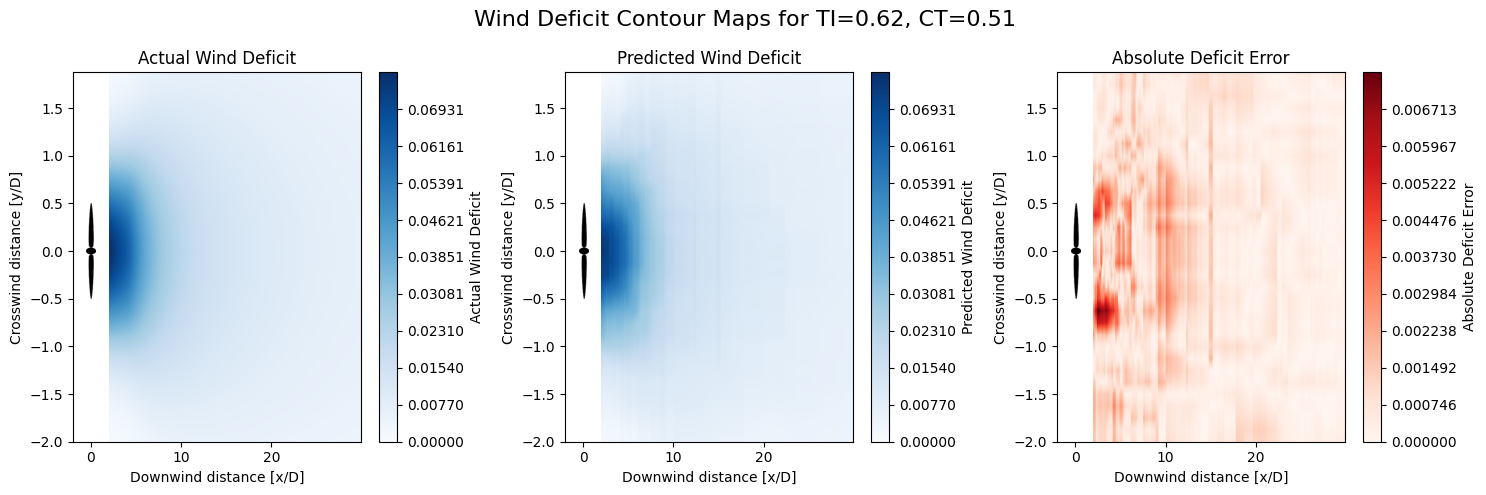

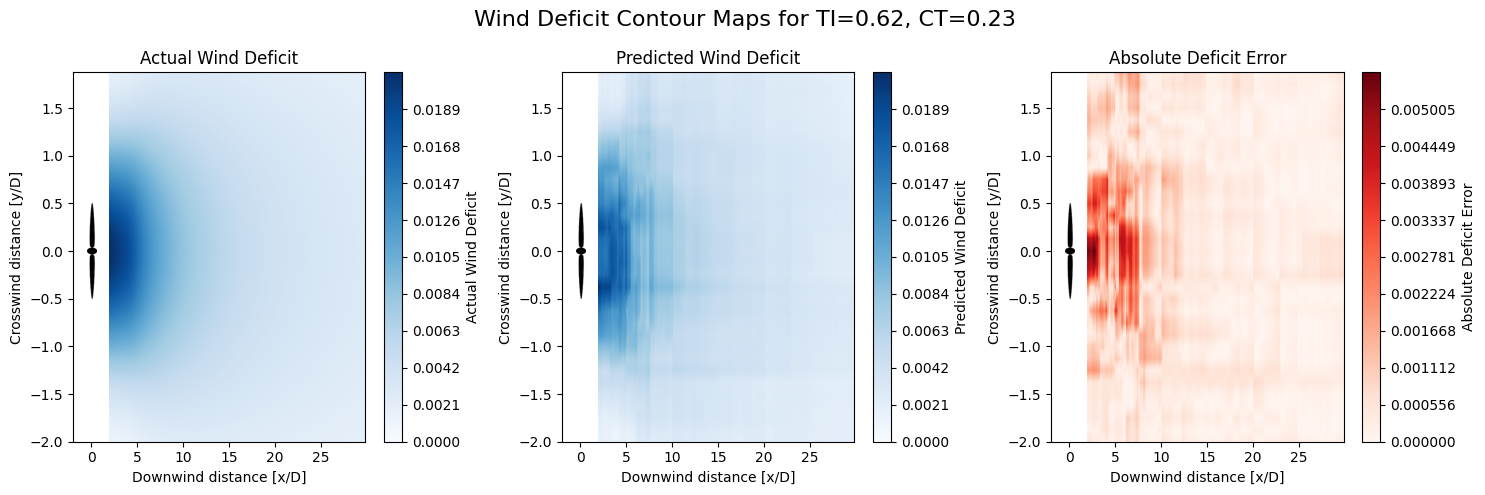

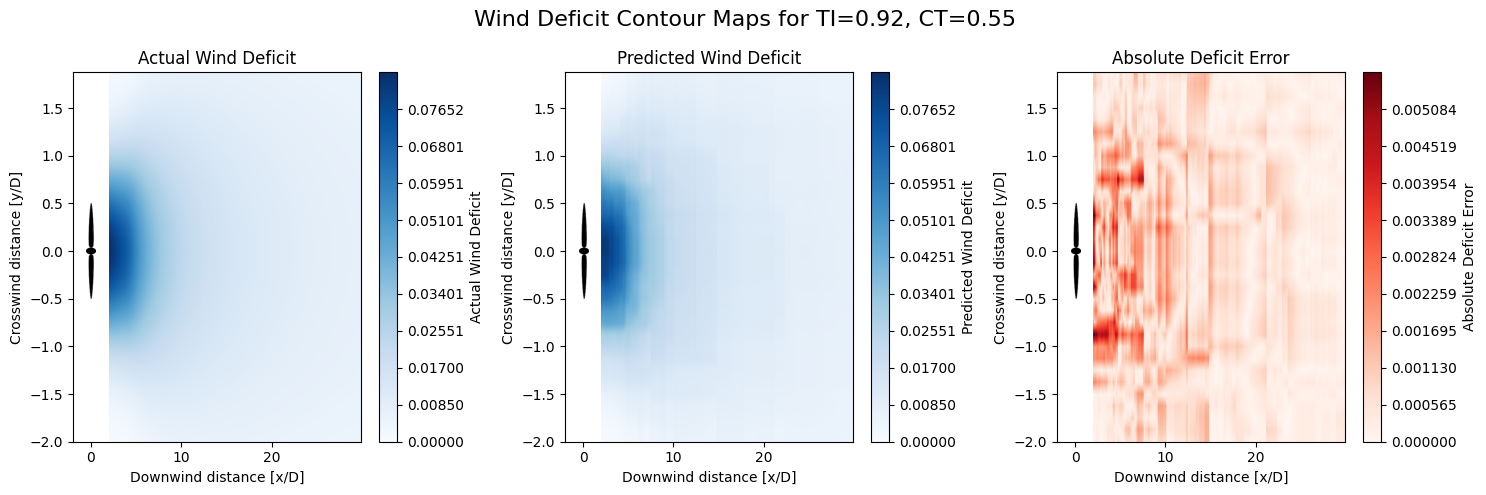

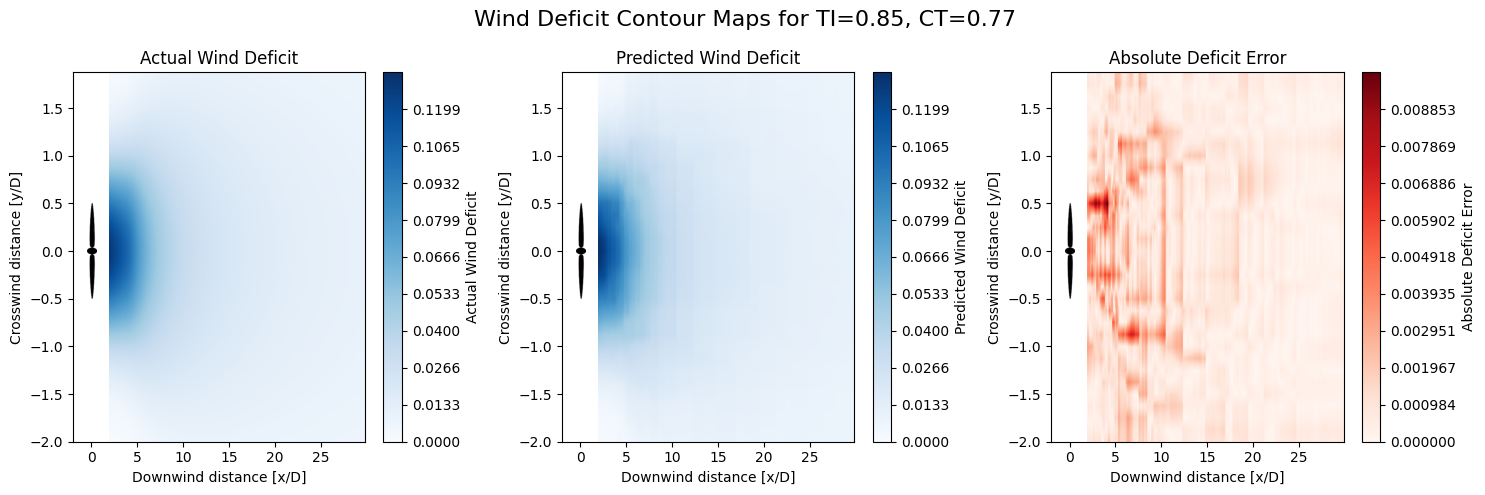

In [12]:
num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

for field_idx in field_indices[:10]:
    ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
    plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')